Bulk objects inspection; apply GAIA->LS filter transformation

In [5]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc

In [6]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [7]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    # plt.grid(alpha=0.5, lw=0.5)
    return ax

def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='median', bins=bins)
    bin_spread, _, _ = stats.binned_statistic(x, y, statistic=nmad, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_spread

-------

In [8]:
# gaia1 and gaia2: DECaLS/DES SGC; gaia3: BASS/MzLS; gaia4: DECaLS NGC
gaia_fn = 'gaia1.fits.gz'
gaia = Table.read('/Users/rongpu/Documents/Data/desi_misc/gaia_from_arjun/'+gaia_fn)
print(len(gaia))

if (gaia_fn=='gaia1.fits.gz') or (gaia_fn=='gaia2.fits.gz'):
    mask = gaia['dec']<31.
    gaia = gaia[mask]
    print(len(gaia))
                                  
if (gaia_fn=='gaia3.fits.gz'):
    mask = gaia['dec']>32.375
    gaia = gaia[mask]
    print(len(gaia))

855294
832837


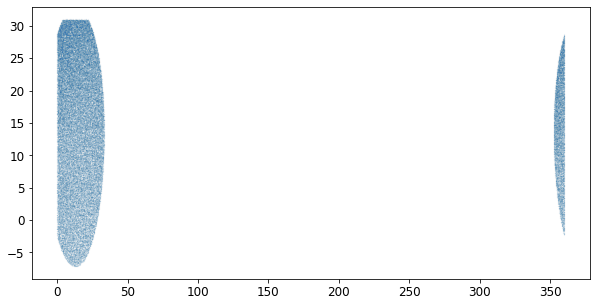

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(gaia['ra'][::10], gaia['dec'][::10], '.', ms=0.1, alpha=0.5)
plt.show()

In [10]:
# Remove duplicates
if len(np.unique(gaia['source_id']))<len(gaia):
    print('Duplicates exist!')
    gaia.sort('source_id')
    mask = gaia['source_id'][1:]==gaia['source_id'][:-1]
    mask = np.concatenate([[False], mask])
    gaia = gaia[~mask]
    
# Remove objects with invalide mask = np.isfinite(gaia['bp_rp'])
mask = np.isfinite(gaia['bp_rp'])
if np.sum(~mask)>0:
    print('{} objects with invalid bp_rp'.format(np.sum(~mask)))
    gaia = gaia[mask]

5812 objects with invalid bp_rp


In [11]:
gaia[:3]

source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_excess_noise,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mag,mag,km / s,km / s,,K,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,bytes13,float32,float32
76963928454294528,30.405325440623816,0.043583431054268214,13.590807698246374,0.03664475649931496,0.33554165612151027,0.04642950419390585,0.13216090759396082,0.09400519417895174,-3.1181403854342555,0.07185068285862767,0.06237348510707128,15.1999445,0.79629135,nan,nan,NOT_AVAILABLE,5916.0,nan
77105250058122496,31.130029533950907,0.0774492987192934,14.24676239294676,0.05998435449859614,1.8761122912295791,0.07765567241924295,16.651649895808433,0.16389922527077824,-29.872733221707904,0.1150138769657371,0.0,16.770638,1.9164085,nan,nan,NOT_AVAILABLE,3805.0,0.0298
77130912487449088,32.37128459494941,0.07443325440018038,13.434907812764257,0.06289497066991939,0.8894613198536169,0.0873026631127525,1.0491718451165948,0.1494118293145261,-3.9093751275915083,0.11921383320957166,0.13129823279539063,16.415583,1.2788982,nan,nan,NOT_AVAILABLE,4771.9053,0.3197


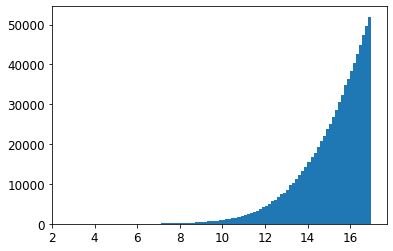

In [12]:
plt.hist(gaia['phot_g_mean_mag'], 100);

In [13]:
# Apply GAIA-LS transformation
from scipy.interpolate import interp1d
transform_interp = {}
for band in ['g', 'r', 'z']:
    tmp = np.load('data/gaia_decals_{}_transform.npz'.format(band))
    bin_center, bin_median, bin_spread = tmp['arr_0'], tmp['arr_1'], tmp['arr_2']
    transform_interp[band] = interp1d(bin_center, bin_median, bounds_error=False, fill_value='extrapolate', kind='linear')
    gaia['decals_'+band] = gaia['phot_g_mean_mag'] + transform_interp[band](gaia['bp_rp'])

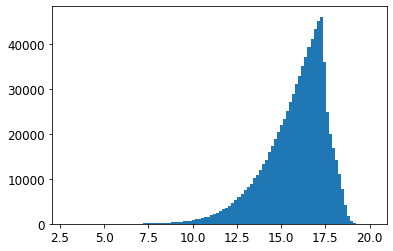

In [14]:
plt.hist(gaia['decals_g'], 100);

In [15]:
# mask = (gaia['phot_g_mean_mag']>16) & ((gaia['phot_g_mean_mag']<18))
# plt.figure(figsize=(8, 8))
# plt.plot((gaia['bp_rp'])[mask], (gaia['decals_g']-gaia['phot_g_mean_mag'])[mask], '.', ms=0.3)
# plt.xlabel('GAIA_BP - GAIA_RP')
# plt.ylabel('DECaLS_G - GAIA_G')
# plt.axis([-0.5, 3.5, -0.5, 3.])
# plt.grid(alpha=0.5)
# plt.show()

------
## Narrow bin of DECaLS g-band magnitude

In [16]:
decals_g_min_list = [10.5, 13.0, 15.5]
decals_g_max_list = [10.51, 13.01, 15.51]

In [17]:
radius_in_bin = []
flux_in_bin = []

for mag_index in range(len(decals_g_min_list)):
        
    decals_g_min, decals_g_max = decals_g_min_list[mag_index], decals_g_max_list[mag_index]
    print('\n', decals_g_min, decals_g_max)
    
    plot_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/plots/04/'    
    band = 'g'
    # img_type = '-resid'
    img_type = ''
    pixscale_str = '0.262'
    pixscale = float(pixscale_str)

    nsamp = 50

    idx = np.where((gaia['decals_g']>decals_g_min) & (gaia['decals_g']<decals_g_max))[0]
    print(len(idx))
    if len(idx)>nsamp:
        np.random.seed(1)
        idx = np.random.choice(idx, size=nsamp, replace=False)
        # print(len(idx))

    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
        
    radius_arr = []
    flux_arr = []

    for index in idx:

        print('phot_g_mean_mag = ', gaia['phot_g_mean_mag'][index])

        ra, dec = gaia['ra'][index], gaia['dec'][index]

        download_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/512/'
        file_path = os.path.join(download_dir, gaia_fn[:-8], 'gaia_{}_{}{}_{}.fits'.format(index, band, img_type, pixscale_str))
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))

        if not os.path.isfile(file_path):
            url = 'http://legacysurvey.org/viewer/cutout.fits?ra={:f}&dec={:f}&layer=dr8{}&pixscale={}&bands={}&size=512'.format(ra, dec, img_type, pixscale_str, band)
            cmd = 'wget -O '+file_path+' \"'+url+'\"'
            print(cmd)
            os.system(cmd)

        img_raw = fitsio.read(file_path)
        img = img_raw / (pixscale**2)

        grid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
        xx, yy = np.meshgrid(grid, grid)
        radius = np.sqrt(xx**2 + yy**2).flatten()

        # Remove masked pixels
        mask = img.flatten()!=0
        radius = radius[mask]
        flux = img.flatten()[mask]

        bin_center, _, bin_median, bin_spread = binned_stats(radius, flux, bins=np.linspace(0., 250, 251))
        radius_arr.append(bin_center)
        flux_arr.append(bin_median)

        # vrange = 0.5
        # ax = plot_cutout(img, pixscale, vmin=-vrange, vmax=vrange)
        # ax.set_title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_image.png'))
        # plt.close()

        # plt.figure(figsize=(8, 6))
        # plt.plot(radius, flux, '.', ms=0.5)
        # plt.plot(bin_center, bin_median, c='C1')
        # plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
        # plt.axis([0, 20, -1, 5])
        # plt.axhline(0, lw=1, color='r')
        # plt.grid(alpha=0.5)
        # plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile.png'))
        # plt.close()

        # plt.figure(figsize=(8, 6))
        # plt.loglog(radius, flux, '.', ms=0.5)
        # plt.plot(bin_center, bin_median, c='C1')
        # plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
        # plt.axis([.5, 30, .02, 200])
        # plt.grid(alpha=0.5)
        # plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile_log.png'))
        # plt.close()

    radius_arr = np.array(radius_arr)
    flux_arr = np.array(flux_arr)
    
    x, _, y, _ = binned_stats(radius_arr.flatten(), flux_arr.flatten(), bins=np.linspace(0., 250, 251))
    radius_in_bin.append(x)
    flux_in_bin.append(y)


 10.5 10.51
76
phot_g_mean_mag =  8.972918
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_149985_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=8.283779&dec=16.525003&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  10.245076
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_576756_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=24.390512&dec=29.059314&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  9.592792
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_30848_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=5.050067&dec=17.133160&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  9.807976
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_786671_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=14.532202&dec=0.090670&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  9.781017
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/5

phot_g_mean_mag =  9.483917
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_28684_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=12.027661&dec=19.147713&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  10.267965
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_129343_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=17.702472&dec=16.632374&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  10.045524
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_7675_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=31.703429&dec=14.753081&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  9.825273
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_773248_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=354.731206&dec=15.673173&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  10.259077
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gai

/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)



 13.0 13.01
450
phot_g_mean_mag =  12.326518
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_807456_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=10.335964&dec=1.313852&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  12.557931
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_638540_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=19.540234&dec=2.057938&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  12.749029
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_272205_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=16.221534&dec=20.186689&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  12.636481
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_169776_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=12.900537&dec=25.627996&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  12.45364
wget -O /Users/rongpu/Downloads/gaia_star_cut

phot_g_mean_mag =  12.721361
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_232852_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=27.887189&dec=6.221431&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  12.29642
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_280696_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=7.240450&dec=21.687583&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  12.543097
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_460557_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=7.375268&dec=30.997948&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  12.288289
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_508680_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=356.721474&dec=16.697345&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  12.71508
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gai

/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)



 15.5 15.51
1502
phot_g_mean_mag =  15.059988
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_49040_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=14.302640&dec=13.799178&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  14.3392
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_43071_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=13.866033&dec=12.124613&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  14.903981
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_667369_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=28.224846&dec=17.622679&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  15.167197
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_182748_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=3.068776&dec=13.847824&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  15.123462
wget -O /Users/rongpu/Downloads/gaia_star_cuto

phot_g_mean_mag =  15.084888
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_629526_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=9.672580&dec=24.884625&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  15.035501
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_23026_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=6.367938&dec=14.078655&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  15.135974
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_29649_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=11.365839&dec=19.538437&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  15.076497
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gaia_562642_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=14.632313&dec=29.732498&layer=dr8&pixscale=0.262&bands=g&size=512"
phot_g_mean_mag =  14.997745
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia1/gai

/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


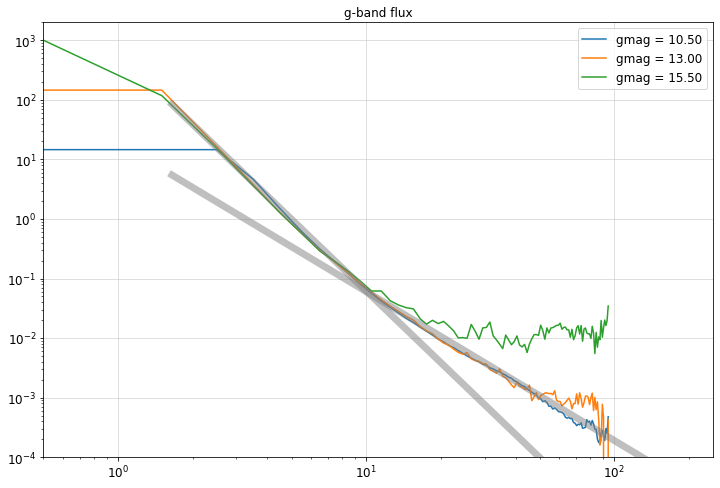

In [18]:
plt.figure(figsize=(12, 8))
for index in range(len(flux_in_bin)):
    # normalize the flux to 13th magnitude stars
    norm = 10**((decals_g_min_list[index]-13)/2.5)
    plt.loglog(radius_in_bin[index], flux_in_bin[index]*norm, lw=1.5, alpha=1., 
               label='{}mag = {:.2f}'.format(band, decals_g_min_list[index]))

x = radius_in_bin[0].copy()
y1 = 1.711 - 4.*(x-1.179)
y2 = 0 - 2.5*(x-1.179)
plt.loglog(np.exp(x), np.exp(y1), lw=7, alpha=0.5, color='grey')
plt.loglog(np.exp(x), np.exp(y2), lw=7, alpha=0.5, color='grey')
# plt.loglog(np.exp(x), (np.exp(y1)+np.exp(y2)), lw=7, alpha=0.5, color='red')
plt.title('{}-band flux'.format(band))

plt.axis([.5, 250, .0001, 2000])
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [19]:
t = Table()
t['radius'] = radius_in_bin[0]
for index in range(len(flux_in_bin)):
    t['flux_{}_{:.2f}'.format(band, decals_g_min_list[index])] = flux_in_bin[index]
mask = t['radius']>=95.5
t = t[~mask]

t.write('data/DECaLS_SGC_profiles_g.txt', format='ascii.commented_header')